# Spam classifier using BERT

Ce projet est pédagogique, je souhaite comprendre le fonctionnement de BERT et son utilisation pour un classifieur de spam.

On définit le processeur à utiliser, si on a un GPU on l'utilise, sinon on utilise le CPU.

In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

J'importe le dataset, le l'encode en latin-1 pour éviter les erreurs d'encodage, et je le formate de façon à n'avoir que deux colonnes : text et label. Label vaudra 1 si c'est un spam, 0 sinon.

In [2]:
import pandas as pd

df = pd.read_csv("./spam.csv", encoding="latin-1", usecols=["v1", "v2"])
df = df.rename(columns={"v1": "label", "v2": "text"})
df["label"] = df["label"].map({"spam": 1, "ham": 0})
print(df.head())

   label                                               text
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...


Je vérifie la distribution des labels. Il y a 13.5% de spam.

In [3]:
distribution = df['label'].value_counts(normalize = True)
print(distribution)

label
0    0.865937
1    0.134063
Name: proportion, dtype: float64


On divise le dataset en train (70%), validation (15%) et test (15%). On vérifie la distribution des labels dans les différents datasets pour voir si c'est bien uniforme.

Grâce aux seeds, peu importe si on relance le code, les datasets seront identiques.

In [8]:
from sklearn.model_selection import train_test_split

train_text, rest_text, train_labels, rest_labels = train_test_split(
    df['text'], df['label'], 
    random_state=1234, # Seed pour la reproductibilité, on évite un biais
    test_size=0.3, 
    stratify=df['label']
)

val_text, test_text, val_labels, test_labels = train_test_split(
    rest_text, rest_labels, 
    random_state=5678, 
    test_size=0.5, 
    stratify=rest_labels
)

print("Distribution des labels dans le train set :", train_labels.value_counts(normalize=True))
print("Distribution des labels dans le validation set :", val_labels.value_counts(normalize=True))
print("Distribution des labels dans le test set :", test_labels.value_counts(normalize=True))

Distribution des labels dans le train set : label
0    0.865897
1    0.134103
Name: proportion, dtype: float64
Distribution des labels dans le validation set : label
0    0.866029
1    0.133971
Name: proportion, dtype: float64
Distribution des labels dans le test set : label
0    0.866029
1    0.133971
Name: proportion, dtype: float64


In [32]:
# Récupérer le texte de la troisième entrée de train_text
print(train_text.iloc[2])  # Affiche le texte à l'index 2

Then we gotta do it after that


On import un modèle BERT pré-entraîné et son tokenizer.
bert-base-uncased est un modèle BET de taille standard avec 12 couches, 768 dimensions cachées et 12 têtes d'attention.
Toutes les lettres sont en minuscules et les accents sont supprimés.

In [9]:
from transformers import AutoModel, BertTokenizerFast

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=False)

On affiche l'histogramme de la longueur des textes dans le train set.

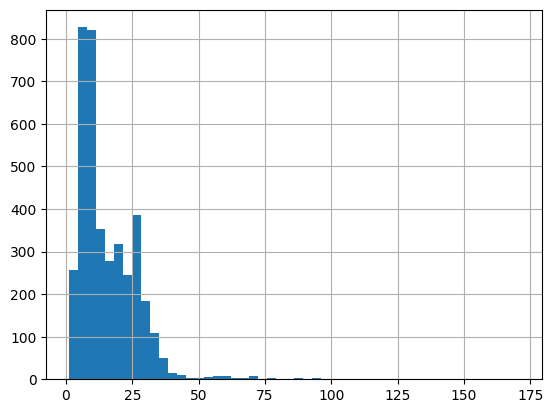

In [10]:
import matplotlib.pyplot as plt

seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 50)

plt.show()

On tokenize le train set, le validation set et le test set.

In [11]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True,
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length = True,
    truncation = True,
)

print(tokens_train[0])
print(tokens_val[0])
print(tokens_test[0])

/home/lezarman/.virtualenvs/BERT-from-scratch-CDIVNApH/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
Encoding(num_tokens=25, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])


On crée les tenseurs pour le train set, le validation set et le test set.

In [12]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

J'affiche les tenseurs ci-dessous.
train_seq, c'est la séquence d'identifiant de tokens pour chaque texte. En gros pour chaque token on cherche dans un index le mot correspondant et on le remplace par son identifiant. 

Tous les vecteurs ont la même longueur, 25. Cela permet d'éviter la malédiction de la dimensionnalité.


In [19]:
print("train_seq :\n", train_seq)
print("Premier vecteur train_seq : ", train_seq[0])
print("Troisième vecteur train_seq : ", train_seq[2])
print("Longueur des vecteurs train_seq : ", len(train_seq[0]))


train_seq :
 tensor([[  101,  6694,  1005,  ...,  2611, 11199,   102],
        [  101,  2423,  2361,  ...,  1012, 19067,   102],
        [  101,  2059,  2057,  ...,     0,     0,     0],
        ...,
        [  101,  7592, 18237,  ...,     0,     0,     0],
        [  101,  1045,  2228,  ...,  2412,  2131,   102],
        [  101,  7592,  1010,  ...,  2424,  2070,   102]])
Premier vecteur train_seq :  tensor([  101,  6694,  1005,  1055, 20661,  2085,   999, 19067,  2102,  2611,
         2030,  1038, 29027,  2063,  1004, 24471,  2171,  1004,  2287,  1010,
         1041,  2290,  2611, 11199,   102])
Troisième vecteur train_seq :  tensor([  101,  2059,  2057, 10657,  2079,  2009,  2044,  2008,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0])
Longueur des vecteurs train_seq :  25


Nous allons maintenant afficher le mask.
train_mask, c'est la séquence d'attention. Si un texte est plus court que les autres, les valeurs non utilisées sont marquées par des 0.
Comme vous pouvez le voir juste au dessus, le troisième texte est plus court que le premier, on voit que les 0 du troisième vecteur sont les mêmes que sur son mask.

In [20]:
print("train_mask :\n", train_mask)
print("Premier vecteur train_mask : ", train_mask[0])
print("Troisième vecteur train_mask : ", train_mask[2])
print("Longueur des vecteurs train_mask : ", len(train_mask[0]))



train_mask :
 tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
Premier vecteur train_mask :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1])
Troisième vecteur train_mask :  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0])
Longueur des vecteurs train_mask :  25


Le tenseur train_y contient le label pour chaque texte.
Il est donc de la même longueur que le train set (3900 ici).
Toujours, 1 si c'est un spam, 0 sinon.

In [22]:
print("train_y :\n", train_y)
print("Longueur du vecteur train_y : ", len(train_y))

train_y :
 tensor([1, 1, 0,  ..., 0, 0, 0])
Longueur du vecteur train_y :  3900


Pour finir, voici les shapes des tenseurs. Comme on peut le déduire des cellules précédente, ils représentent le nombre des vecteurs et la taille des vecteurs.

In [23]:
print(train_seq.shape)
print(train_mask.shape)
print(train_y.shape)

torch.Size([3900, 25])
torch.Size([3900, 25])
torch.Size([3900])


Nous allons maintenant créer un DataLoader pour le train set.

Un DataLoader est un itérateur qui permet de parcourir le dataset de manière efficace.

Il prend en entrée un dataset et un sampler, et renvoie un batch de données à chaque itération.

Le sampler est un objet qui permet de récupérer les indices des données à utiliser pour le batch.

RandomSampler est un sampler qui permet de récupérer des indices de manière aléatoire.
SequentialSampler est un sampler qui permet de récupérer des indices de manière séquentielle.

On définit la taille du batch à 32.

D'abord on regroupe les tenseurs dans TensorDataset.

Ensuite on crée le RandomSampler pour éviter que l'algorithme apprenne l'ordre des données (ce qui n'a aucun intérêt ici et pourrait mener à une sur-adaptation)

Enfin on crée le DataLoader qui va nous permettre de parcourir le dataset.

On utilise des batch de 32 données pour optimiser les performances. Si on devait charger les 3900 données en mémoire on serait limité par la mémoire de la machine.

In [26]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

print(train_data.tensors)

(tensor([[  101,  6694,  1005,  ...,  2611, 11199,   102],
        [  101,  2423,  2361,  ...,  1012, 19067,   102],
        [  101,  2059,  2057,  ...,     0,     0,     0],
        ...,
        [  101,  7592, 18237,  ...,     0,     0,     0],
        [  101,  1045,  2228,  ...,  2412,  2131,   102],
        [  101,  7592,  1010,  ...,  2424,  2070,   102]]), tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]]), tensor([1, 1, 0,  ..., 0, 0, 0]))


Nous voulons éviter que les paramètres du BERT soient mis à jour dans le processus d'apprentissage.

Dans d'autres termes, on veut conserver les apprentissages de BERT durant sa phase de pré-entraînement et les utiliser tel quel dans notre modèle.

En effet, avec notre petit dataset, mettre à jour les paramètres de BERT pourrait facilement mener à une sur-adaptation.

Pour ce faire, on désactive le calcul des gradients pour les paramètres de BERT.

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

On va utiliser le module nn servant à construire des réseaux de neurones.

La classe hérite donc de nn.Module, ce qui est essentiel pour que PyTorch puisse reconnaître notre classe comme un modèle de réseau de neurones.

Voici une explication de chaque attribut de la classe :
- self.bert : c'est le modèle BERT que nous avons importé et chargé précédemment.
- self.dropout : Il s'agit de la couche de Dropout. Elle est appliquée sur les sorties de la couche précédente pour réduire le sur-apprentissage. Dans notre cas, on applique une Dropout de 0.1, ce qui signifie que 10% des neurones sont désactivés (probabilité de 0.1 qu'un neurone donné soit désactivé).
- self.relu : Il s'agit de la fonction d'activation ReLU. Elle est appliquée à la sortie de la couche précédente pour introduire une non-linéarité dans le modèle. Sans cela, les réseaux de neurones ne pourraient pas apprendre des fonctions non-linéaires.
- self.fc1 : C'est la première couche linéaire (fully connected layer n°1). Elle prend en entrée les sorties de la couche précédente et les transforme en une sortie de taille 512.
- self.fc2 : C'est la seconde couche linéaire (fully connected layer n°2). Elle prend en entrée les sorties de la première couche linéaire et les transforme en une sortie de taille 2 (spam ou ham).
- self.softmax : Il s'agit de la fonction softmax. Elle est appliquée à la sortie de la seconde couche linéaire pour transformer les valeurs en probabilités. Pour faire simple, elle permet de contenir les valeurs entre 0 et 1 et de s'assurer que la somme des probabilités de spam et ham est égale à 1.

Ces attributs sont initialisés dans la méthode __init__.

La méthode forward est la méthode qui définit le forward pass du modèle. Elle décrit comment les données sont propagées à travers le modèle. Elle prend en entrée les tenseurs sent_id et mask.
- sent_id : sentence id, c'est la séquence d'identifiant de tokens pour chaque texte.
- mask : c'est la séquence d'attention. Si un texte est plus court que les autres, les valeurs non utilisées sont marquées par des 0.

On applique ensuite la première couche linéaire à la sortie de la couche précédente.

Puis on applique la fonction d'activation ReLU.

Puis on applique la Dropout.

Enfin on applique la seconde couche linéaire.

La sortie de cette méthode est la probabilité de spam ou ham pour chaque texte, qu'on rend exploitable grâce à la fonction softmax.


In [33]:
import torch.nn as nn

class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
        print(cls_hs.shape)
        print(sent_id.shape)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.softmax(x)

Ici, on instancie notre modèle.

In [ ]:
model = BERT_Arch(bert)
model = model.to(device)

Bon là faut que j'étudie AdamW en vrai, petite pause sur ce notebook.